# Tutorial: Using `fastai.data` for Pets

> Using `DataSource`, `Pipeline`, `PipedList`, and `Transform`s to load the Pets dataset.

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

Let's see how to use `fastai.data` to process the Pets dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

We grab the items and split indices:

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

## Using only `Transform`

We'll need this function to create consistently sized tensors from image files:

In [ ]:
def resized_image(fn, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

We need to create a `Transform` that converts from an index to our `x` and `y` for modeling.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        super().__init__()
        self.items,self.train_idx = items,train_idx
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)
        
    def encodes(self, i):
        o = self.items[i]
        return resized_image(o), self.o2i[self.labeller(o)]
    
    def decodes(self, o): return o[0],self.vocab[o[1]]
    def shows(self, o, ax=None): show_image(o[0], ax, title=o[1])

We can now create the `PetTfm`. We pass the training set indices to the constructor so it can create a vocab from only those items.

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets[0]
x.shape,y

(torch.Size([3, 128, 128]), 23)

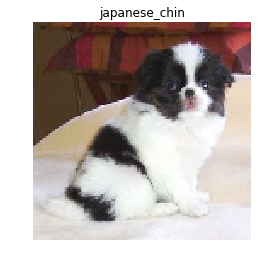

In [ ]:
pets.show((x,y))

## Using `Pipeline` to create Siamese model dataset

A *Siamese* model needs a dataset with two images as input, and a boolean output that is `True` if the two images are the "same" (e.g. are pictures of the same breed of pet). Custom structures like this are often easiest to create using `Pipeline`, which makes no assumptions about the structure of your input or output data.

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels = items,labels
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        self.clsmap = {k:ListContainer(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "Tuple of `i`th image and a random image from same or different class"
        item,lbl = self.items[i],self.labels[i]
        is_same = torch.rand(1).item()>0.5
        othercls = self.clsmap[lbl] if is_same else self.idxs
        otherit = random.choice(othercls)
        # check we didn't get same class coincidentally
        is_same = self.labels[otherit]==lbl
        return (item,self.items[otherit]),is_same
    
    def shows(self,o):
        (x1,x2),y = o
        show_image(torch.cat([x1,x2], dim=2), title=y)

In [ ]:
sp = SiamesePair(items, items.mapped(labeller))
resized_images = mapper(resized_image)
pipe = Pipeline([sp, lambda o: (resized_images(o[0]),o[1])])
pipe.setup()

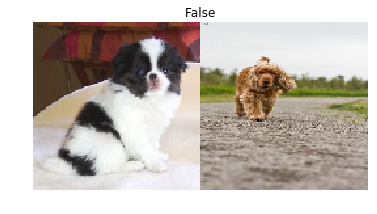

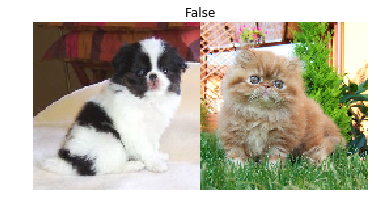

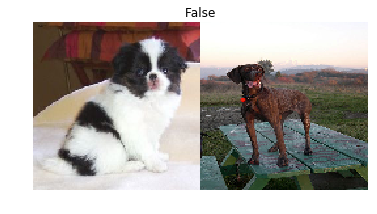

In [ ]:
for _ in range(3): pipe.show_at(0)

## Using `PipeList`

`Pipeline` simply runs a sequence of transforms in order, and `PipeList` applies a list of pipelines lazily to items of a collection, creating one output per pipeline. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.

In [ ]:
class _Cat(Transform):
    def __init__(self,train_idx): self.o2i,self.train_idx = None,train_idx
    def encodes(self,o): return self.o2i[o] if self.o2i else o
    def decodes(self, o): return self.vocab[o]
    def setup(self, items): self.vocab,self.o2i = uniqueify(items, sort=True, bidir=True)
    def shows(self,o,ctx): show_title(o,ctx)

In [ ]:
timg = Transform(Image.open, shows=lambda o,ctx:show_image(o,ax=ctx))
c = _Cat(split_idx[0])
pl = Pipelines.create(items, [[timg, ImageResizer(128), ImageToByteTensor(), ByteToFloatTensor()], [labeller, c]])

In [ ]:
t = pl[0]

In [ ]:
x,y = pl.decode(t)
x.shape,y

(torch.Size([128, 128, 3]), 'japanese_chin')

In [ ]:
t[0].shape

torch.Size([3, 128, 128])

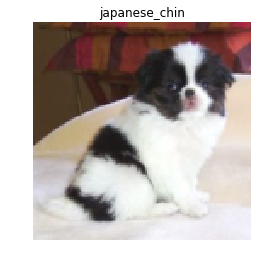

In [ ]:
pl.show(t)

## DataSource (not working)

In [ ]:
c = _Cat(split_idx[0])
tfm = Pipelines([[timg, ImageResizer(128), ImageToByteTensor(), ByteToFloatTensor()], [labeller, c]])

In [ ]:
pets = DataSource(items, tfm, filts=split_idx)

To access an element we need to specify index/filter (the latter defaults to 0 - so this is item 0 of the validation set):

In [ ]:
x,y = pets.valid[0]
x.shape,y

(torch.Size([3, 128, 128]), 7)

We can also use the `train` and `valid` properties to access the same information.

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index/filt to `decoded`.

In [ ]:
xy = pets.decode((x,y), filt=1)
xy[1]

'Persian'

In [ ]:
xy = pets.decode_at(0)
test_eq(type(xy[1]),str)

We're now ready to show our items.

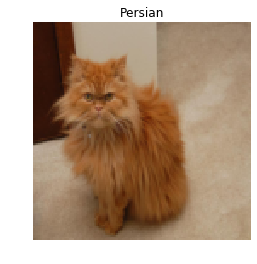

In [ ]:
pets.show((x,y))

We can now use this to feed a `DataLoader` and view a batch.

In [ ]:
# export
@docs
class TfmDataLoader(GetAttr):
    "Transformed `DataLoader` using a `Pipeline` of `tfms`"
    _xtra = 'batch_size num_workers dataset sampler pin_memory'.split()
    
    def __init__(self, dl, tfms=None, **kwargs):
        self.dl,self.tfm = dl,Pipeline(tfms)
        self.default = self.dl # for `GetAttr`
        for k,v in kwargs.items(): setattr(self,k,v)
    
    def __len__(self): return len(self.dl)
    def __iter__(self): return map(self.tfm, self.dl)
    def decode(self, o): return self.tfm.decode(o)
    def one_batch(self): return next(iter(self))
    def decode_batch(self): return self.decode(self.one_batch())
            
    _docs = dict(decode="Decode `o` using `tfm`",
                 one_batch="Grab first batch of `dl`",
                 decode_batch="Decoded first batch of `dl`")

In [ ]:
trn_dl = TfmDataLoader(DataLoader(pets.train,9))
b = trn_dl.one_batch()

In [ ]:
test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))

In [ ]:
test_eq(len(b2), 9)

In [ ]:
b=b[0]

In [ ]:
b[0][0].shape

torch.Size([128, 128])

In [ ]:
b2 = list(zip(*listify(b)))
bd = ListContainer(zip(*map(pets.decode,b2)))

In [ ]:
test_eq(len(bd[0]), 9)
test_eq(bd[0][0].shape, (128,128,3))

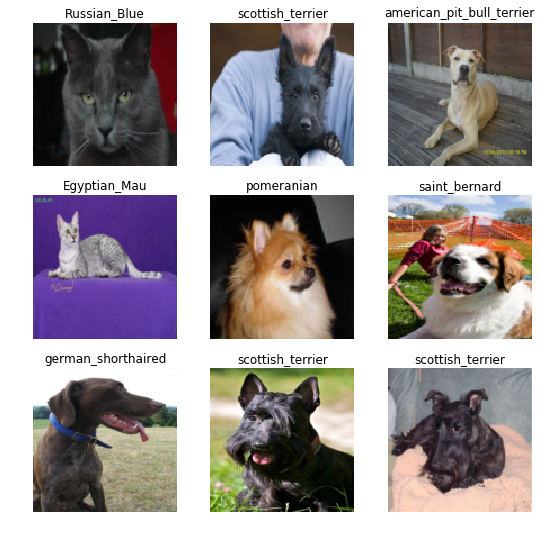

In [ ]:
show_image_batch(bd)

## fin -